In [25]:
import numpy as np
from scipy.optimize import minimize, fsolve
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

class BrigoMercurioModel:
    def __init__(self, t=0.003):
        # NSS parameters
        self.beta0 = 0.0494
        self.beta1 = -0.0059
        self.beta2 = -0.0106
        self.beta3 = -0.0045
        self.tau1 = 1.4997
        self.tau2 = 4.9999
        self.t = t
        
        # Market data
        self.T_values = [1, 3, 5, 7, 10, 20]
        self.setup_market_data()
        
    def setup_market_data(self):
        """Setup market data including forward rates and implied volatilities"""
        # Calculate Forward Swap Rates
        self.Kf_values = {T: self.Kf(T) for T in self.T_values}
        
        # Setup strike matrix
        strike_matrix = {
            "Maturity (years)": list(self.Kf_values.keys()),
            "0.95 K_f": [0.95 * Kf for Kf in self.Kf_values.values()],
            "K_f": list(self.Kf_values.values()),
            "1.05 K_f": [1.05 * Kf for Kf in self.Kf_values.values()]
        }
        self.strikes = pd.DataFrame(strike_matrix)
        
        # Setup implied volatility matrix
        iv_matrix = {
            "Maturity (years)": list(self.Kf_values.keys()),
            "0.95 K_f": [0.157, 0.176, 0.175, 0.168, 0.155, 0.142],
            "K_f": [0.152, 0.164, 0.161, 0.156, 0.148, 0.126],
            "1.05 K_f": [0.146, 0.157, 0.158, 0.152, 0.140, 0.121]
        }
        self.sigmas = pd.DataFrame(iv_matrix)
        
        # Calculate market cap prices
        self.calculate_market_cap_prices()

    def zcy(self, T):
        """Nelson-Siegel-Svensson Zero-Coupon Yield"""
        term1 = (1 - np.exp(-T/self.tau1)) / (T/self.tau1)
        term2 = term1 - np.exp(-T/self.tau1)
        term3 = (1 - np.exp(-T/self.tau2)) / (T/self.tau2) - np.exp(-T/self.tau2)
        return self.beta0 + self.beta1 * term1 + self.beta2 * term2 + self.beta3 * term3

    def P(self, T):
        """Discount factor P(t,T)"""
        z_T = self.zcy(T)
        z_t = self.zcy(self.t)
        return np.exp(-z_T * T + z_t * self.t)

    def forward_rate(self, T1, T2):
        """Forward rate F(T1,T2)"""
        P_t_T1 = self.P(T1)
        P_t_T2 = self.P(T2)
        return (1 / (T2 - T1)) * np.log(P_t_T1 / P_t_T2)

    def instantaneous_forward_rate(self, T):
        """Instantaneous forward rate f(0,t)"""
        dt = 0.01
        P_T = self.P(T)
        P_T_plus_dt = self.P(T + dt)
        return -(1/dt) * np.log(P_T_plus_dt/P_T)

    def Kf(self, T):
        """Forward swap rate"""
        tau = 0.25
        denominator = 0
        numerator = self.P(tau) - self.P(T)
        for t in np.arange(2 * tau, T + tau, tau):
            denominator += tau * self.P(t)
        return numerator / denominator

    def cap_mkt_price(self, tn, K, sigma):
        """Calculate market cap price using Black's formula"""
        cap_sum = 0
        tau = 0.25
        t_values = np.arange(tau, tn + tau, tau)
        
        for i in range(len(t_values) - 1):
            F_j = self.forward_rate(t_values[i], t_values[i + 1])
            P_j = self.P(t_values[i + 1])
            v_j = sigma * np.sqrt(t_values[i])
            
            d1 = (np.log(F_j / K) + 0.5 * v_j**2) / v_j
            d2 = d1 - v_j
            
            caplet_price = tau * P_j * (F_j * norm.cdf(d1) - K * norm.cdf(d2))
            cap_sum += caplet_price
            
        return cap_sum

    def calculate_market_cap_prices(self):
        """Calculate all market cap prices"""
        self.cap_mkt_prices_df = pd.DataFrame(index=self.strikes.index, 
                                            columns=self.strikes.columns[1:])
        
        for i in range(self.strikes.shape[0]):
            tn = self.strikes.iloc[i, 0]
            for j in range(1, self.strikes.shape[1]):
                K = self.strikes.iloc[i, j]
                sigma = self.sigmas.iloc[i, j]
                self.cap_mkt_prices_df.iloc[i, j-1] = self.cap_mkt_price(tn, K, sigma)
        
        self.cap_mkt_prices_df.insert(0, "Maturity (years)", self.strikes["Maturity (years)"])

    def get_gamma(self, k, sigma):
        """Calculate γ = √(k² + 2σ²)"""
        return np.sqrt(k**2 + 2*sigma**2)

    def calculate_bcir(self, t, T, k, gamma):
        """Calculate b_cir(t,T)"""
        return 2 * gamma * np.exp(gamma*(T-t)) / ((k + gamma)*(np.exp(gamma*(T-t)) - 1) + 2*gamma)

    def calculate_acir(self, t, T, k, theta, sigma, gamma):
        """Calculate A_cir(t,T)"""
        num = 2 * gamma * np.exp((k+gamma)*(T-t)/2)
        denom = (k + gamma)*(np.exp(gamma*(T-t)) - 1) + 2*gamma
        power = 2*k*theta/sigma**2
        return (num/denom)**power

    def bond_price_bm(self, t, T, params, x):
        """Calculate Brigo-Mercurio bond price"""
        k, theta, sigma, x0, f1 = params
        gamma = self.get_gamma(k, sigma)
        
        bcir = self.calculate_bcir(t, T, k, gamma)
        acir = self.calculate_acir(t, T, k, theta, sigma, gamma)
        
        P0t = self.P(t)
        P0T = self.P(T)
        
        Abm = (P0T/P0t) * acir * np.exp(-bcir * f1)
        return Abm * np.exp(-bcir * x)

    def cap_price_bm(self, params, strike_rate, payment_dates):
        """Calculate Brigo-Mercurio cap price"""
        tau = 0.25
        K = 1/(1 + strike_rate * tau)
        
        total_price = 0
        for t in payment_dates[1:]:  # Skip first date as it's the start
            bond_price = self.bond_price_bm(t-tau, t, params, params[3])
            put_price = max(K - bond_price, 0)
            total_price += put_price
            
        return total_price

    def objective_function(self, params):
        """Optimization objective function"""
        total_error = 0
        kf_multipliers = [0.95, 1.0, 1.05]
        
        for i, T in enumerate(self.T_values):
            for j, mult in enumerate(kf_multipliers):
                payment_dates = np.arange(0.25, T+0.25, 0.25)
                strike_rate = mult * self.Kf_values[T]
                
                model_price = self.cap_price_bm(params, strike_rate, payment_dates)
                market_price = self.cap_mkt_prices_df.iloc[i, j+1]
                
                if market_price > 0:
                    relative_error = ((model_price - market_price) / market_price) ** 2
                    total_error += relative_error
                
        return total_error

    def calibrate(self):
        """Calibrate model parameters"""
        initial_params = [2.5, 0.0008, 0.15, 0, 0.02]  # [k, theta, sigma, x0, f1]
        bounds = [(1, 4), (0.0005, 0.002), (0.05, 0.3), (0.001, 0.03), (0.001, 0.03)]
        
        result = minimize(self.objective_function, 
                        initial_params,
                        bounds=bounds,
                        method='L-BFGS-B')
        
        return result.x, result.fun

    def calculate_bm_implied_vol(self, params, K, T):
        """Calculate implied volatility from Brigo-Mercurio model price"""
        payment_dates = np.arange(0.25, T+0.25, 0.25)
        bm_price = self.cap_price_bm(params, K, payment_dates)
        
        def vol_objective(sigma):
            return self.cap_mkt_price(T, K, sigma) - bm_price
        
        implied_vol = fsolve(vol_objective, x0=0.15)[0]
        return implied_vol

    def print_calibration_results(self, optimal_params, min_error):
        """Print calibration results in a formatted table"""
        print("Calibrated Parameters:")
        print("    Parameter     Value")
        print(f"    θ (theta) {optimal_params[1]:.6f}")
        print(f"    κ (kappa) {optimal_params[0]:.6f}")
        print(f"    σ (sigma) {optimal_params[2]:.6f}")
        print(f"    v0 {optimal_params[3]:.6f}")
        print(f"Objective Value {min_error:.6f}\n")

    def plot_results(self, optimal_params):
        """Plot calibration results in a 2x3 grid"""
        # Create figure with 2 rows and 3 columns
        fig = plt.figure(figsize=(15, 10))
        gs = plt.GridSpec(2, 3, figure=fig)
        
        # Create subplots for prices
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[0, 2])
        
        # Create subplots for volatilities
        ax4 = fig.add_subplot(gs[1, 0])
        ax5 = fig.add_subplot(gs[1, 1])
        ax6 = fig.add_subplot(gs[1, 2])
        
        price_axes = [ax1, ax2, ax3]
        vol_axes = [ax4, ax5, ax6]
        kf_multipliers = [0.95, 1.0, 1.05]
        
        for i, (mult, price_ax, vol_ax) in enumerate(zip(kf_multipliers, price_axes, vol_axes)):
            market_prices = []
            model_prices = []
            implied_vols = []
            market_vols = []
            
            for T in self.T_values:
                payment_dates = np.arange(0.25, T+0.25, 0.25)
                strike_rate = mult * self.Kf_values[T]
                
                # Get prices
                market_idx = self.strikes[self.strikes["Maturity (years)"]==T].index[0]
                if mult == 1.0:
                    col_name = "K_f"
                else:
                    col_name = f"{mult:.2f} K_f"
                    
                market_price = self.cap_mkt_prices_df[col_name].iloc[market_idx]
                model_price = self.cap_price_bm(optimal_params, strike_rate, payment_dates)
                
                market_prices.append(market_price)
                model_prices.append(model_price)
                
                # Get volatilities
                implied_vol = self.calculate_bm_implied_vol(optimal_params, strike_rate, T)
                market_vol = self.sigmas[col_name].iloc[market_idx]
                
                implied_vols.append(implied_vol)
                market_vols.append(market_vol)
            
            # Plot prices
            price_ax.plot(self.T_values, market_prices, 'bo-', label='Market')
            price_ax.plot(self.T_values, model_prices, 'r--', label='Model')
            price_ax.set_xlabel('Maturity (years)')
            price_ax.set_ylabel('Price')
            price_ax.grid(True)
            price_ax.legend()
            price_ax.set_title(f'Cap Prices (K = {mult}Kf)')
            
            # Plot volatilities
            vol_ax.plot(self.T_values, market_vols, 'bo-', label='Market')
            vol_ax.plot(self.T_values, implied_vols, 'r--', label='Model')
            vol_ax.set_xlabel('Maturity (years)')
            vol_ax.set_ylabel('Implied Volatility')
            vol_ax.grid(True)
            vol_ax.legend()
            vol_ax.set_title(f'Implied Volatilities (K = {mult}Kf)')
        
        plt.tight_layout()
        return fig


Calibrated Parameters:
    Parameter     Value
    θ (theta) 0.000500
    κ (kappa) 1.000000
    σ (sigma) 0.050000
    v0 0.001000
Objective Value 83.726541



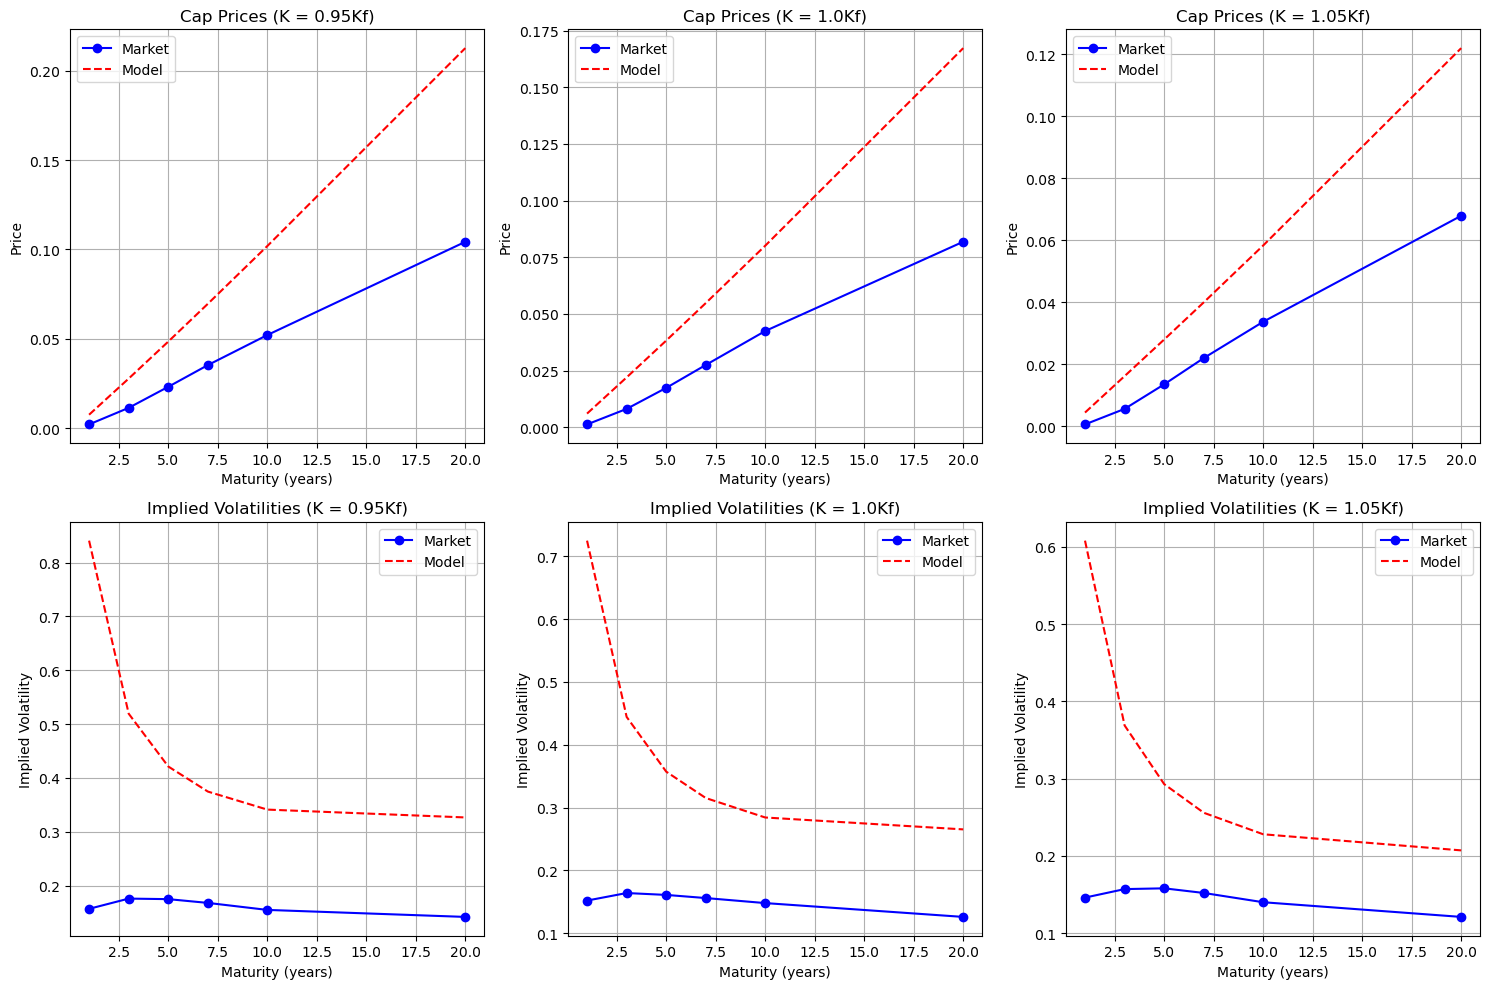

In [27]:
# Example usage
model = BrigoMercurioModel()
optimal_params, min_error = model.calibrate()

# Print results
model.print_calibration_results(optimal_params, min_error)

# Plot results
fig = model.plot_results(optimal_params)
plt.show()